In [1]:
#from Week_4 import G
import networkx as nx
G = nx.read_gpickle("css_graph.gpickle")

# Part 1: Centrality and Assortativity

# Exercise 1: Mixing Patterns and Assortativity.

In [2]:
import netwulf as nw
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcolors
import math
import statistics
import random
from scipy.stats import ttest_1samp

In [3]:
G_lcc = max(nx.connected_components(G), key=len)

# create a subgraph of the largest connected component
G_lcc = G.subgraph(G_lcc)
# convert G_lcc to a Graph object
G = nx.Graph(G_lcc)

#nw.visualize(G_lcc) #visualize largest conneccted componenents
#nw.visualize(G) #visualize whole css graph

In [4]:
#Make all missing top_fields = None
for author in G.nodes:
    if 'top_field' not in G.nodes[author]:
        G.nodes[author]['top_field'] = None


In [5]:
#Compute average neighboors in same top field as each node
def network_mean_same_field(top_fild_name):
    for author in G.nodes:
        G.nodes[author]['Avr_same_field'] = mean_same_field = statistics.mean(map(int, [G.nodes[author][top_fild_name] == field for field 
              in [G.nodes[neighboor][top_fild_name] for neighboor 
                  in G.neighbors(author)]]))
    
    #network average
    network_mean = statistics.mean(map(float, [G.nodes[author]['Avr_same_field'] for author in G.nodes]))
    return network_mean

network_mean = network_mean_same_field('top_field')

In [6]:
top_fields = list(nx.get_node_attributes(G, "top_field").values())

def randomise_top_fields_rand():
    random.shuffle(top_fields)
    for i, author in enumerate(G.nodes):
        G.nodes[author]['top_field_rand'] = top_fields[i]

In [7]:
#Compute average neighboors in same top field as each node 100 times for random top fields
rand_means = [] 
for i in range(100):
    randomise_top_fields_rand()
    rand_means.append(network_mean_same_field('top_field_rand'))
    
#rand_means


In [8]:
#compute the p-value for the null-hypothesis that out network mean occured by random... The p-value is extreemly low
t_stat, p_value = ttest_1samp(rand_means, network_mean)
p_value

4.8065641061101015e-130

In [9]:
#assortativity_coefficient wrt. field
nx.attribute_assortativity_coefficient(G, 'top_field')
#The positive value of r indicates that authors with the same top field are more likely to connect to each other 
#than to authors with the same top fields


0.1770459342206534

In [10]:
#assortativity_coefficient wrt. degree (default)
nx.degree_assortativity_coefficient(G)
#The positive value of r mean s taht the network is aasortative wrt degree i.e. authors with similar degrees are more likely to connect to each other 
#than to authors with differetn degrees


0.03273113319546212

# Exercise 2: Central nodes.

In [11]:
close_centrals = nx.closeness_centrality(G)
top_ClosCentr = sorted(close_centrals.items(), key=lambda x: x[1], reverse=True)[:5]
top_ClosCentr
#We imagine that the scientists with a high closeness centrality have are very well connected, maybe they work in positions with many collaborative papers.

[('2349638', 0.1898230695377863),
 ('1776476', 0.18351786779818338),
 ('80273596', 0.18350570140546274),
 ('2504674', 0.18338412614283822),
 ('1826736', 0.18275452264624323)]

In [12]:
eigenvector = nx.eigenvector_centrality(G, max_iter = 2000)
top_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 scientists by eigenvector centrality:")
for node, centrality in top_eigenvector:
    print(node, centrality)

Top 5 scientists by eigenvector centrality:
1682773 0.3620889533881609
80273596 0.23130524513351672
2349638 0.21151551884374878
2504674 0.18865015691541237
1851304 0.1575045084006729


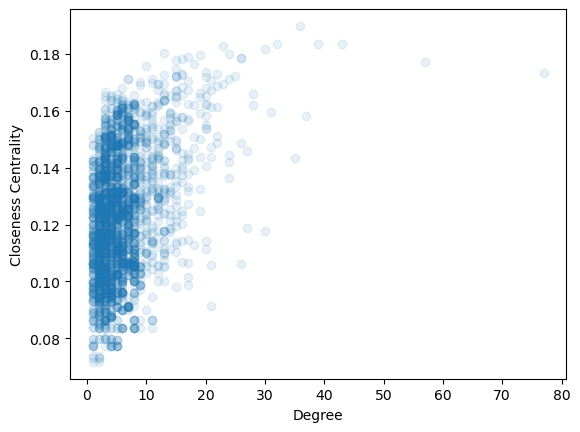

In [13]:
degree = dict(G.degree())
plt.scatter(list(degree.values()),list(close_centrals.values()), alpha=0.1)
plt.xlabel('Degree')
plt.ylabel('Closeness Centrality')
plt.show()

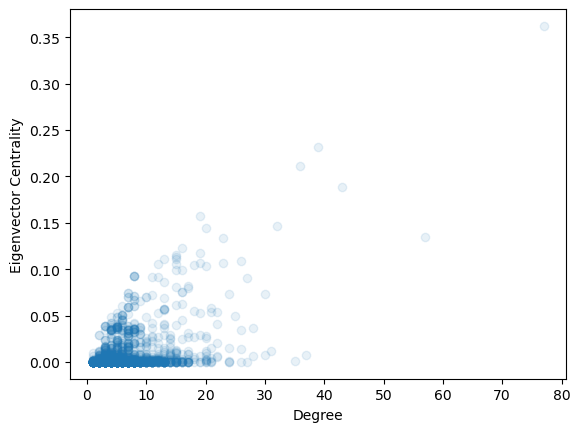

In [14]:
plt.scatter(list(degree.values()),list(eigenvector.values()), alpha=0.1)
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.show()
#there does not seem to be much of a correlation, i.e. your number of neighboors does not semm to dictate how central they are in the network.

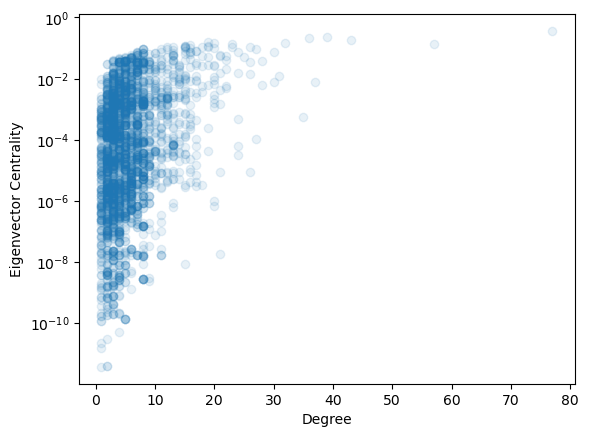

In [15]:
plt.scatter(list(degree.values()),list(eigenvector.values()), alpha=0.1)
plt.xlabel('Degree')
plt.ylabel('Eigenvector Centrality')
plt.yscale("log")
plt.show()
#there does not seem to be much of a correlation, i.e. your number of neighboors does not semm to dictate how central they are in the network.

Even with the logscale, I suspect that the small correlation that we see is simply a function of the minimum poosible value depending on the degree, for all the nodes that have a very low score. 

# Part 2: Community detection

# Exercise 3: Zachary's karate club

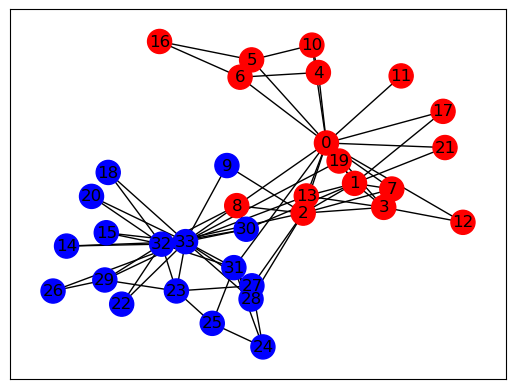

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw

G = nx.karate_club_graph()

# Define colors for each club
club_colors = {'Mr. Hi': 'red', 'Officer': 'blue'}

# Get node colors based on club attribute
node_colors = [club_colors[G.nodes[n]['club']] for n in G.nodes()]

# Draw the graph with node colors
nx.draw_networkx(G, with_labels=True, node_color=node_colors)

# Show the plot
plt.show()


In [32]:
import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw

G = nx.karate_club_graph()
dict = nx.get_node_attributes(G,'club')
nx.set_node_attributes(G,dict,"group")
results = nw.visualize(G)

In [33]:
def compute_modularity(G, partition):
    m = G.number_of_edges()
    Q = 0
    for c in set(partition.values()):
        Lc = [(i, j) for i, j in G.edges() if partition[i] == c and partition[j] == c]
        k_c = sum([G.degree[i] for i in G.nodes() if partition[i] == c])
        L = [(i, j) for i, j in G.edges()]
        Q += len(Lc)/len(L) - (k_c/(2*len(L)))**2
    return Q


Modularity is a measure of the quality of a partitioning of a network into communities or modules. It compares the number of edges within communities to the expected number of edges if the network were randomly wired. The higher the modularity score, the better the partitioning. It ranges from -1 to 1, where a score of 1 indicates a perfect partitioning and a score of 0 indicates a random partitioning.          !!!!!!!!(edit)!!!!!!!!!!

In [34]:
#Q4
partition = nx.get_node_attributes(G, 'club')
modularity = compute_modularity(G, partition)
print(f"The modularity of the Karate Club split partitioning is {modularity}")

The modularity of the Karate Club split partitioning is 0.3582347140039447


In [35]:
#Q5
import random
import copy

def double_edge_swap(G):
    N = len(G.edges()) # number of edges in the network
    """
    This function creates a new network by swapping edges in the original network.
    G: the original network
    N*1.4: the number of swaps
    """
    G_new = copy.deepcopy(G) # create an identical copy of the original network
    nodes = list(G.nodes()) # list of nodes in the network

    for i in range(int(N*2.1)):
        edges = list(G_new.edges()) # list of edges in the network
        # choose two random edges
        e1, e2 = random.sample(edges, 2)
        u, v = e1
        x, y = e2

        # make sure the chosen edges are not adjacent
        if (u != v) and (v != x) and (v != y) and (u != x) and (u != y) and (x != y) and (u, y) not in edges and (x, v) not in edges and (y, u) not in edges and (v, x) not in edges:
            # add the new edges and remove the old ones
            G_new.add_edge(u, y)
            G_new.add_edge(x, v)
            G_new.remove_edge(u, v)
            G_new.remove_edge(x, y)

                
    if len(G_new.edges()) != len(G.edges()):
        raise ValueError("degree of nodes in the OG network and rand version are not the same")
    return G_new


In [36]:
partition = nx.get_node_attributes(G, 'club')
modularities = []
for i in range(1000):
    G_new = double_edge_swap(G)
    modularities.append(compute_modularity(G_new,partition))

In [37]:
modularities = np.array(modularities)
modularities_std = np.std(modularities)
modularities_mean = np.mean(modularities)
print(f"modularities std = {modularities_std}")
print(f"modularities mean = {modularities_mean}")

modularities std = 0.04716764065316734
modularities mean = -0.0081755424063117


Conclusion: 

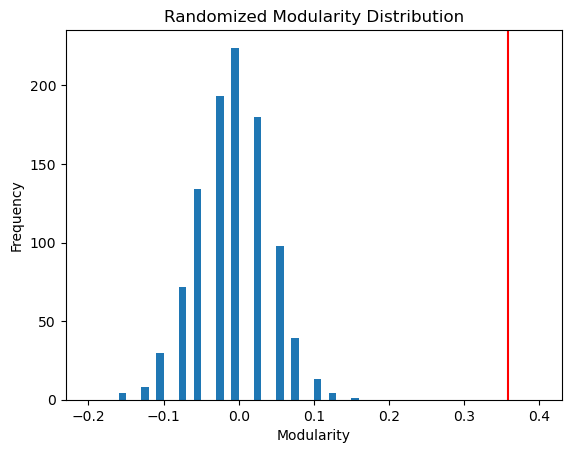

In [38]:
fig, ax = plt.subplots()
bins = np.arange(-0.2, 0.4, 0.01)
ax.hist(modularities, bins=bins)
ax.axvline(x=modularity, color='r')
ax.set_xlabel("Modularity")
ax.set_ylabel("Frequency")
ax.set_title("Randomized Modularity Distribution")
plt.show()

In [39]:
import community as community_louvain
partition = community_louvain.best_partition(G)

In [40]:
#Q11
import networkx as nx
import community

# Find communities using the Louvain algorithm
partition = community.best_partition(G)

# Compute the modularity of the partition
modularity = community.modularity(partition, G)

# Print the modularity value
print('Modularity:', modularity)


Modularity: 0.44385412567230753


In [41]:
#Q12
groups_club = 2
groups_louvin = 4
D = np.zeros(groups_club*groups_louvin).reshape(groups_louvin,groups_club)
for i, club in enumerate(list(set(partition.values()))):
    for j, group_name in enumerate(list(set(nx.get_node_attributes(G, "club").values()))):
        D[i,j] = sum(partition[x] == club and nx.get_node_attributes(G, "club")[x] == group_name for x in list(G.nodes()))
print("Confusion matrix for groups")
D

Confusion matrix for groups


array([[ 0., 11.],
       [ 4.,  0.],
       [ 0.,  5.],
       [13.,  1.]])

# Exercise 4: Community detection on the network of Computational Social Scientists

In [42]:
import networkx as nx
import community
import netwulf as nw

G = nx.read_gpickle("css_graph.gpickle")

# Find communities using the Louvain algorithm
partition = community.best_partition(G)

# Compute the modularity of the partition
modularity = community.modularity(partition, G)

# Print the modularity value
print('Modularity:', modularity)

Modularity: 0.9477932218067847


In [48]:
with open('partition.txt', 'w') as file:
    for node, community in partition.items():
        file.write(str(node) + ',' + str(community) + '\n')

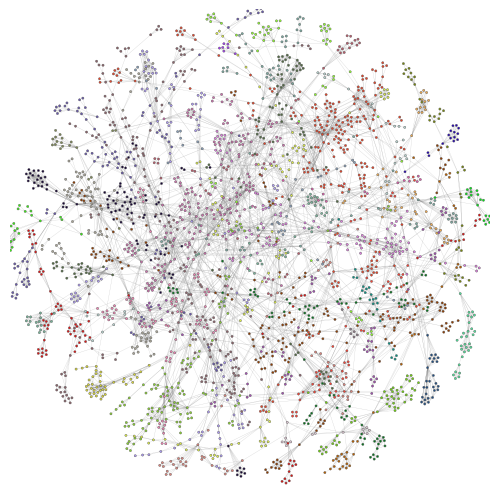

In [43]:
# Visualization using netwulf
nx.set_node_attributes(G,partition,"group")
#Extarct the largets connected component from the network and save it as the new network
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
G = G.subgraph(largest_component)
results = nw.visualize(G)

In [ ]:

#GraveYard  --------       don't use      -----------
def assortivity_wrt_field(G, attribute):
    attr_dict = nx.get_node_attributes(G, attribute)
    unique_attr = set(list(attr_dict.values()))
    m = G.number_of_edges()
    
    Mix = np.zeros((len(unique_attr), len(unique_attr)))
    for i, att_i in enumerate(unique_attr):
        for j, att_j in enumerate(unique_attr):
            Mix[i,j] = len([(ie, je) for ie, je in G.edges() if attr_dict[ie] == att_i and attr_dict[je] == att_j])
            
    return Mix